In [1]:
import logging, os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
import scipy
import pandas as pd

### 1. Walk through the data

In [2]:
### Walk through all directory and files
for dir_path, dir_name, file_name in os.walk("data"):
    print(f"There are {len(dir_name)} directories and {len(file_name)} images in '{dir_path}'.")

There are 3 directories and 0 images in 'data'.
There are 2 directories and 0 images in 'data\test'.
There are 0 directories and 234 images in 'data\test\normal'.
There are 0 directories and 390 images in 'data\test\pneumonia'.
There are 2 directories and 0 images in 'data\train'.
There are 0 directories and 1341 images in 'data\train\normal'.
There are 0 directories and 3875 images in 'data\train\pneumonia'.
There are 2 directories and 0 images in 'data\val'.
There are 0 directories and 8 images in 'data\val\normal'.
There are 0 directories and 8 images in 'data\val\pneumonia'.


In [3]:
### Another way find how many images
number_pneumonia_images_train = len(os.listdir("data/train/pneumonia"))

number_pneumonia_images_train

3875

In [4]:
### Get the class names
data_train_dir = pathlib.Path("data/train/")
class_names = np.array(sorted([item.name for item in data_train_dir.glob('*')]))

print(class_names)

['normal' 'pneumonia']


In [5]:
### Viewing image
def view_image(target_dir, target_class):
    target_folder = target_dir + target_class

    # Get random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read image then plot it using matplotlib
    # img = mpimg.imread(target_folder + "/" + random_image[0])
    img = cv2.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");
    
    return img

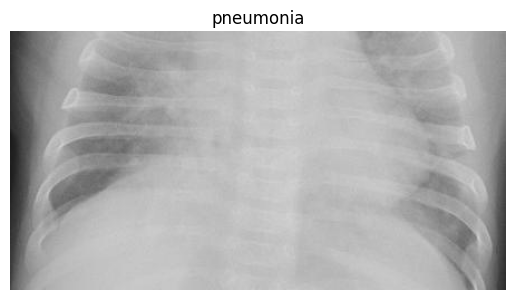

In [6]:
### View random image from the training dataset
img = view_image(target_dir = "data/train/", target_class = "pneumonia")     

In [7]:
### View the images, just a big array/tensor
img

array([[[ 45,  45,  45],
        [ 47,  47,  47],
        [ 50,  50,  50],
        ...,
        [139, 139, 139],
        [137, 137, 137],
        [137, 137, 137]],

       [[ 45,  45,  45],
        [ 47,  47,  47],
        [ 50,  50,  50],
        ...,
        [145, 145, 145],
        [143, 143, 143],
        [144, 144, 144]],

       [[ 45,  45,  45],
        [ 47,  47,  47],
        [ 50,  50,  50],
        ...,
        [142, 142, 142],
        [141, 141, 141],
        [142, 142, 142]],

       ...,

       [[ 72,  72,  72],
        [ 80,  80,  80],
        [ 91,  91,  91],
        ...,
        [ 50,  50,  50],
        [ 47,  47,  47],
        [ 45,  45,  45]],

       [[ 72,  72,  72],
        [ 81,  81,  81],
        [ 91,  91,  91],
        ...,
        [ 50,  50,  50],
        [ 47,  47,  47],
        [ 45,  45,  45]],

       [[ 72,  72,  72],
        [ 81,  81,  81],
        [ 90,  90,  90],
        ...,
        [ 50,  50,  50],
        [ 47,  47,  47],
        [ 44,  44,  44]]

In [8]:
### View image shape, there are 2 channels
img.shape

(232, 445, 3)

In [9]:
### Get all the pixel values between 0 & 1
img/ 255. 

array([[[0.17647059, 0.17647059, 0.17647059],
        [0.18431373, 0.18431373, 0.18431373],
        [0.19607843, 0.19607843, 0.19607843],
        ...,
        [0.54509804, 0.54509804, 0.54509804],
        [0.5372549 , 0.5372549 , 0.5372549 ],
        [0.5372549 , 0.5372549 , 0.5372549 ]],

       [[0.17647059, 0.17647059, 0.17647059],
        [0.18431373, 0.18431373, 0.18431373],
        [0.19607843, 0.19607843, 0.19607843],
        ...,
        [0.56862745, 0.56862745, 0.56862745],
        [0.56078431, 0.56078431, 0.56078431],
        [0.56470588, 0.56470588, 0.56470588]],

       [[0.17647059, 0.17647059, 0.17647059],
        [0.18431373, 0.18431373, 0.18431373],
        [0.19607843, 0.19607843, 0.19607843],
        ...,
        [0.55686275, 0.55686275, 0.55686275],
        [0.55294118, 0.55294118, 0.55294118],
        [0.55686275, 0.55686275, 0.55686275]],

       ...,

       [[0.28235294, 0.28235294, 0.28235294],
        [0.31372549, 0.31372549, 0.31372549],
        [0.35686275, 0

### 2. Exploratory data analysis

### 3. Data preprocessing

In [10]:
### Set seed
tf.random.set_seed(42)

train_datagen = ImageDataGenerator(
    rescale = 1./ 255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    # validation_split = 0.1, ### Try smaller set of data
)

val_datagen = ImageDataGenerator(
    rescale = 1./ 255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1./ 255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    # validation_split = 0.1 ### Try smaller set of data
)

train_dir_path = "data/train/"
val_dir_path = "data/val/"
test_dir_path = "data/test/"

train_data = train_datagen.flow_from_directory(train_dir_path, batch_size = 32, target_size = (150, 150), 
    class_mode = "binary", seed = 42, subset = 'validation')
val_data = val_datagen.flow_from_directory(val_dir_path, batch_size = 32, target_size = (150, 150),
    class_mode = "binary", seed = 42)
test_data = test_datagen.flow_from_directory(test_dir_path, batch_size = 32, target_size = (150, 150),
    class_mode = "binary", seed = 42, subset = 'validation')

Found 521 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 62 images belonging to 2 classes.


### 4. Model building
Settle overfitting issue, L1 & L2 regularization, Dropout, Early stopping, Data augmentation.

In [11]:
### Create sequential model
model = Sequential()

### First layer
model.add(Conv2D(32, input_shape = (150, 150, 3), kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))

### Second layer
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))

### Third layer
model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))

### Fourth layer
model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))

### Flatten layer
model.add(Flatten())

### Fully connected dense layer
model.add(Dense(512, activation = 'relu'))

### Dropout layer
model.add(Dropout(0.5))

### Output layer
model.add(Dense(1, activation = 'sigmoid'))

### Model summary detail
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 128)       0

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], 
              optimizer = 'adam')

history = model.fit(train_data, epochs = 25,
    steps_per_epoch = len(train_data), validation_data = test_data, validation_steps = len(test_data), callbacks = [early_stopping])

Epoch 1/50
17/17 [==============================] - 18s 996ms/step - loss: 0.6379 - accuracy: 0.7274 - val_loss: 0.6772 - val_accuracy: 0.6290
Epoch 2/50
17/17 [==============================] - 15s 866ms/step - loss: 0.5972 - accuracy: 0.7428 - val_loss: 0.6787 - val_accuracy: 0.6290
Epoch 3/50
17/17 [==============================] - 15s 848ms/step - loss: 0.5638 - accuracy: 0.7428 - val_loss: 0.7206 - val_accuracy: 0.6290
Epoch 4/50
17/17 [==============================] - 15s 858ms/step - loss: 0.5404 - accuracy: 0.7428 - val_loss: 0.7052 - val_accuracy: 0.6290
Epoch 5/50
17/17 [==============================] - 14s 843ms/step - loss: 0.5222 - accuracy: 0.7447 - val_loss: 0.7227 - val_accuracy: 0.6129
Epoch 6/50
17/17 [==============================] - 14s 792ms/step - loss: 0.4816 - accuracy: 0.7658 - val_loss: 0.8437 - val_accuracy: 0.6290
Epoch 7/50
17/17 [==============================] - 14s 819ms/step - loss: 0.5209 - accuracy: 0.7466 - val_loss: 0.7621 - val_accuracy: 0.6290

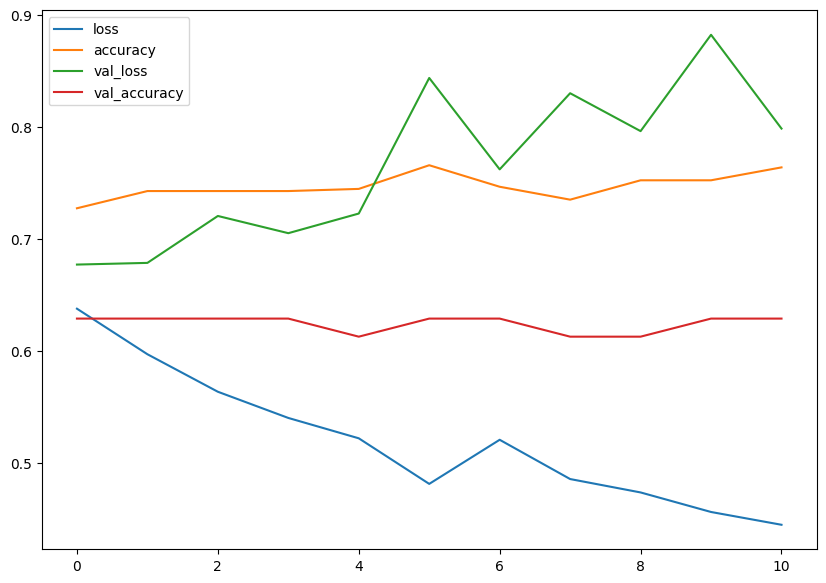

In [13]:
# Plot the training curves
pd.DataFrame(history.history).plot(figsize = (10, 7));

In [14]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label = 'training_loss')
    plt.plot(epochs, val_loss, label = 'val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label = 'training_accuracy')
    plt.plot(epochs, val_accuracy, label = 'val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

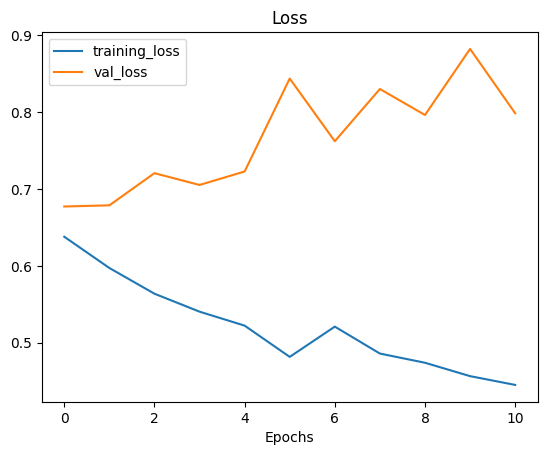

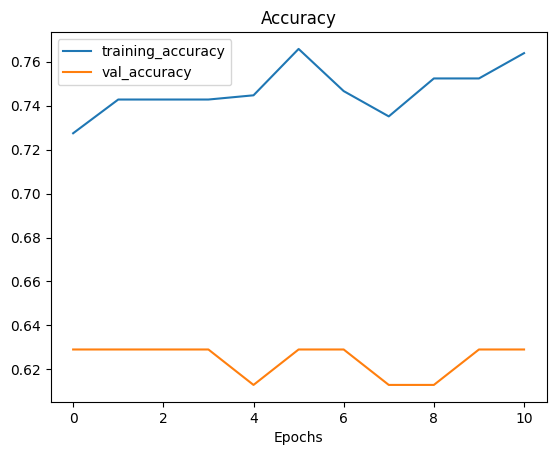

In [15]:
plot_loss_curves(history)

In [28]:
model.evaluate(train_data)

17/17 [==============================] - 8s 445ms/step - loss: 0.6206 - accuracy: 0.7428


[0.6205921769142151, 0.7428023219108582]

In [34]:
predicted_values = model.predict(test_data)

threshold = 0.5
predicted_labels = [class_names[1] if pred >= threshold else class_names[0] for pred in predicted_values]
predicted_labels

2/2 [==============================] - 1s 433ms/step


['pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia',
 'pneumonia']